In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [5]:
dataset_train = pd.read_parquet("C:/Users/Artem/Downloads/dataset_train_small.parquet")
target_train = pd.read_parquet("C:/Users/Artem/Downloads/target_train_small.parquet")

In [6]:
def num_unique_values(x):
    return len(set(x))

def get_features(dataset, target):
    agg_features = dataset.groupby("app_id", as_index=False).agg(
        transaction_number_max=("transaction_number", "max"),
        amnt_min=("amnt", "min"),
        amnt_max=("amnt", "max"),
        amnt_mean=("amnt", "mean"),
        currency_unique=("currency", num_unique_values),
        amnt_count=("amnt", "count")
    )

    agg_features['amnt_range'] = agg_features['amnt_max'] - agg_features['amnt_min']
    agg_features['amnt_ratio'] = agg_features['amnt_mean'] / (agg_features['amnt_max'] + 1)

    features = agg_features.join(target.set_index("app_id"), on="app_id")
    
    return features.drop(columns=["app_id", "flag"]), features[["app_id", "flag"]]

In [7]:
X_train, y_train = get_features(dataset_train, target_train)

In [8]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

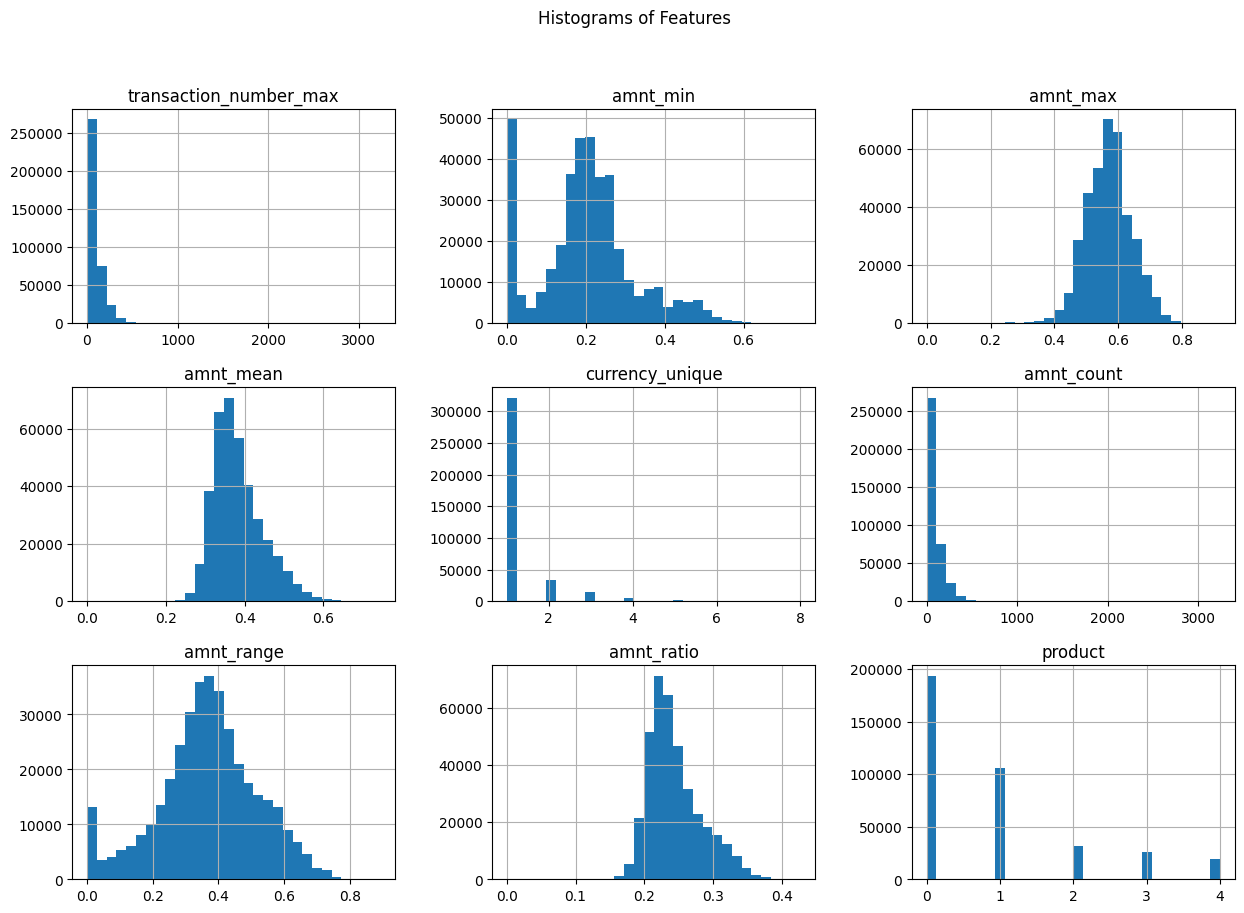

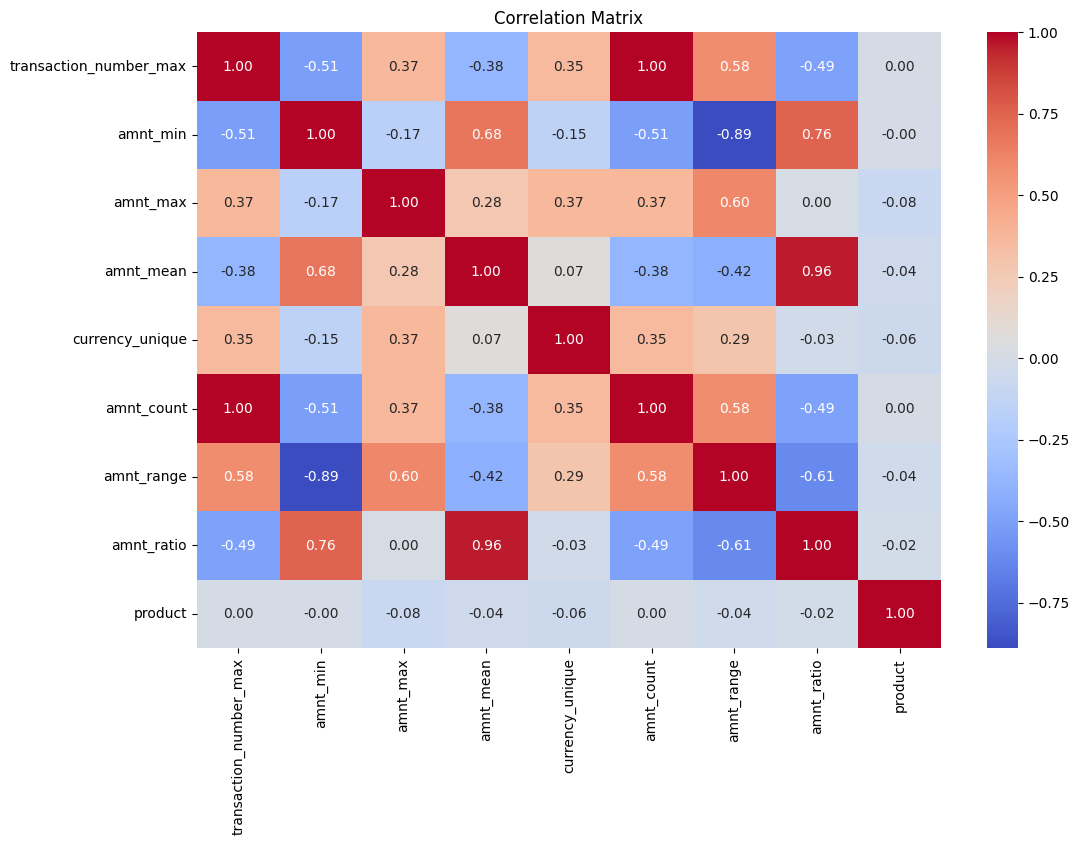

In [28]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = X_train.columns

X_train_df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Features")
plt.show()

# Visualize the correlation matrix
corr_matrix = X_train_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [9]:
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [10]:
gb_model = GradientBoostingClassifier(random_state=42)

In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_split, y_train_split["flag"])

best_gb_model = grid_search.best_estimator_
print(f"Best parameters for Gradient Boosting: {grid_search.best_params_}")

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [20]:
y_valid_pred = best_gb_model.predict_proba(X_valid)[:, 1]
score = 200 * roc_auc_score(y_valid["flag"], y_valid_pred) - 100
print(f"Gini Score: {score}")

Gini Score: 30.191963276754933


In [21]:
cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train["flag"], cv=5, scoring='roc_auc')
print(f"Cross-validated ROC AUC Score: {np.mean(cv_scores)}")

best_gb_model.fit(X_train_scaled, y_train["flag"])

Cross-validated ROC AUC Score: 0.6374028475643495


GradientBoostingClassifier(random_state=42)

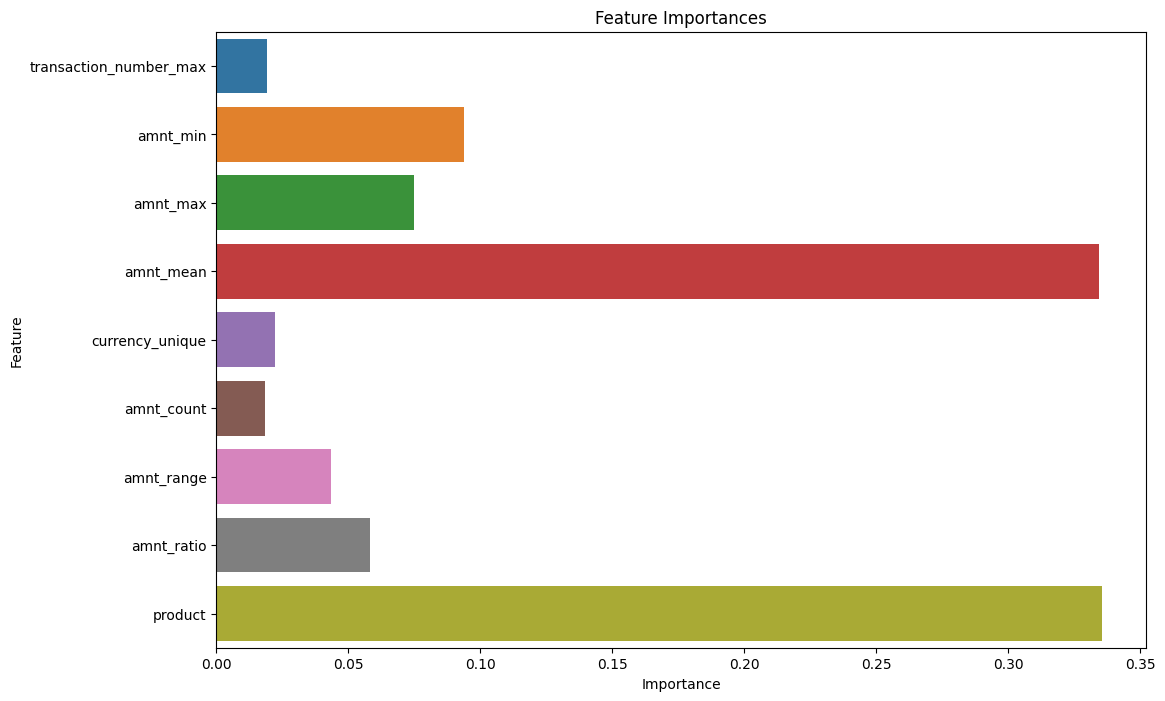

In [25]:
feature_importances = best_gb_model.feature_importances_
features_names = X_train.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features_names)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

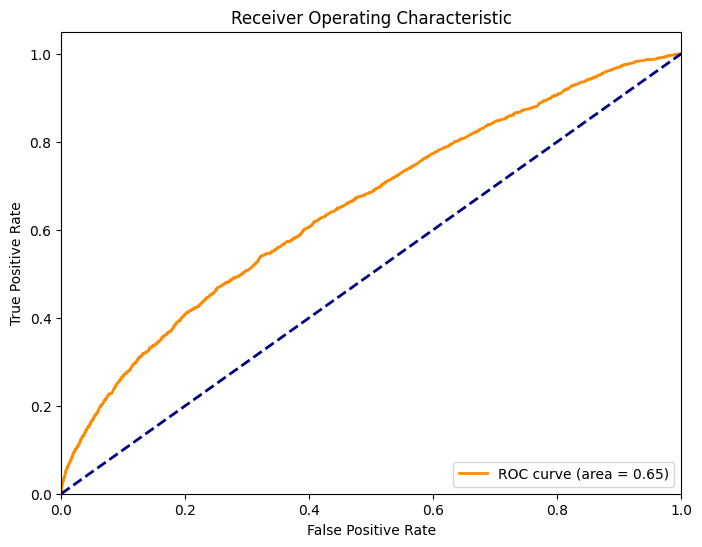

In [27]:
fpr, tpr, _ = roc_curve(y_valid["flag"], y_valid_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
dataset_test = pd.read_parquet("C:/Users/Artem/Downloads/dataset_test.parquet")
target_test = pd.read_parquet("C:/Users/Artem/Downloads/target_test_contest.parquet")
target_test["flag"] = 0

In [15]:
X_test, y_test = get_features(dataset_test, target_test)

In [16]:
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

In [17]:
y_test_pred = best_gb_model.predict_proba(X_test_scaled)[:, 1]
y_test["flag"] = y_test_pred

In [18]:
y_test.to_csv("result.csv", index=False)